In [3]:
"""



3/24/19
"""

from pandas import *
from numpy import *
from matplotlib.pyplot import *
import pickle


In [4]:
fileT=open('tra_pick','rb')
fileC=open('cus_pick','rb')
fileFC=open('fl_itemsssss','rb')
fileBC=open('il_items','rb')

T=pickle.load(fileT)
C=pickle.load(fileC)
FC=pickle.load(fileFC)
BC=pickle.load(fileBC)

#Use only transactions before March 16th
Hr=T[T['th_EventEndDate']<'2019-03-16']['HeaderId']
T=T[isin(T['HeaderId'],Hr)]
FC=FC[isin(FC['HeaderID'],Hr)]
BC=BC[isin(BC['HeaderID'],Hr)]


In [13]:
'''
Apriori analysis for backcourt
'''

BL_code=BC['il_MerchandiseCode'].unique() #List of different item codes
BC_tot=len(BC['HeaderID'].unique()) #Total BL transaction

#Calculates the support for each backcourt item category
BC_sup=BC.groupby('il_MerchandiseCode').count()['HeaderID']/BC_tot

def con12(ID1,ID2):
    one=BC[BC['il_MerchandiseCode']==ID1]
    two=BC[BC['il_MerchandiseCode']==ID2]
    T12=len(where(isin(one['HeaderID'].unique(),two['HeaderID'].unique()))[0])
    T1=len(one['HeaderID'].unique())
    return T12/T1

def lift12(ID1,ID2):
    c12=con12(ID1,ID2)
    return c12/BC_sup[ID2]

#This section of code makes a matrix 67x67 matrix that contains the lift of each item compared
#to each other item in the backcourt. Takes a while to run so it is commented out. 
#It is a little complicated but rich in information. File has been provided. 
'''
LM=zeros([len(BL_code),len(BL_code)])

for i,bid1 in enumerate(BL_code):
    for j,bid2 in enumerate(BL_code):
        LM[i,j]=lift12(bid1,bid2)
        
LM[LM==diagonal(LM)]=0
        
Liftdf=DataFrame(LM,index=BL_code,columns=BL_code)

Liftdf.to_csv('BL_lift_data.csv',float_format='%.2f')
'''

"\nLM=zeros([len(BL_code),len(BL_code)])\n\nfor i,bid1 in enumerate(BL_code):\n    for j,bid2 in enumerate(BL_code):\n        LM[i,j]=lift12(bid1,bid2)\n        \nLM[LM==diagonal(LM)]=0\n        \nLiftdf=DataFrame(LM,index=BL_code,columns=BL_code)\n\nLiftdf.to_csv('BL_lift_data.csv',float_format='%.2f')\n"

In [1]:
'''
Apriori calculation for the different fuel grades and backcourt transactions. 
'''

TCC=T[T['flag_CrossCourt']==1]
BCC=BC[isin(BC['HeaderID'],TCC['HeaderId'].unique())]
FCC=FC[isin(FC['HeaderID'],TCC['HeaderId'].unique())]

FC_tot=len(FC['HeaderID'].unique())


#Cacluates the support for each fuel grade. 
FC_sup=FC.groupby('fl_FuelGradeID').count()['HeaderID']/FC_tot

BCC_tot_sup=len(BCC['HeaderID'].unique())/FC_tot

BCC_sup=BC.groupby('il_MerchandiseCode').count()['HeaderID']/FC_tot


#Function to calcuate confidence and lift
def conCC(FID,BID=None):
    if BID==None:
        A=FC[FC['fl_FuelGradeID']==FID]
        TAB=len(where(isin(A['HeaderID'].unique(),
                           BCC['HeaderID'].unique()))[0])
        TA=len(A['HeaderID'].unique())
    else:
        A=FC[FC['fl_FuelGradeID']==FID]
        B=BCC[BCC['il_MerchandiseCode']==BID]
        TAB=len(where(isin(A['HeaderID'].unique(),
                           B['HeaderID'].unique()))[0])
        TA=len(A['HeaderID'].unique())
    return TAB/TA

def liftCC(FID,BID=None):
    cab=conCC(FID,BID)
    if BID==None:
        return cab/BCC_tot_sup
    else:
        return cab/BCC_sup[BID]

NameError: name 'T' is not defined

In [15]:
'''
Does calcualtion for each fuel grade in relation to backcourt transaction as a whole and saves in csv.
'''

conl=[]
supl=[]
liftl=[]
for conid in ['1','2','3','4','5','6']:
    conl.append(conCC(conid))
    supl.append(FC_sup[conid])
    liftl.append(liftCC(conid))
    
apr_ar=array([supl,conl,liftl])
apr_df=DataFrame(apr_ar.T,index=['1','2','3','4','5','6'],
                 columns=['Support','Confidence','Lift'])

apr_df.to_csv('Apriori_Crosscourt.csv')

In [16]:
'''
Does calcualtion for each fuel grade in relation to each backcourt item and saves in csv.
'''

labl=[]
conl=[]
supl=[]
liftl=[]
for conid in ['1','2','3','4','5','6']:
    for conbid in BL_code:
        conl.append(conCC(conid,conbid))
        supl.append(FC_sup[conid])
        liftl.append(liftCC(conid,conbid))
        labl.append(conid+'->'+conbid)

apr_df_full=DataFrame(array([labl,supl,conl,liftl]).T,
                 columns=['FuelID->il_code','Support','Confidence','Lift'])

apr_df_full.to_csv('Apriori_Crosscourt_detail.csv')

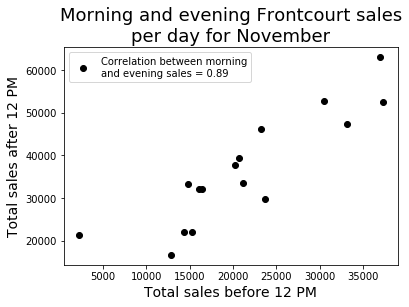

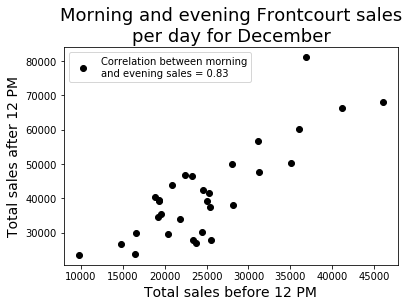

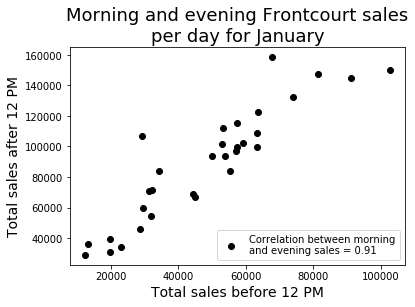

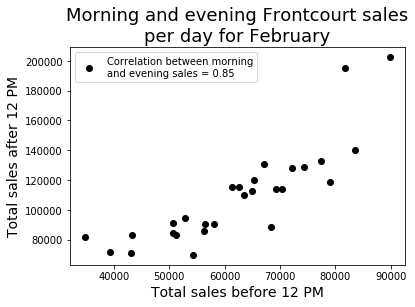

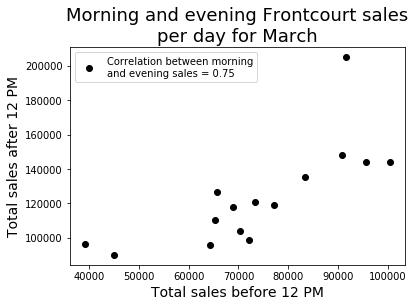

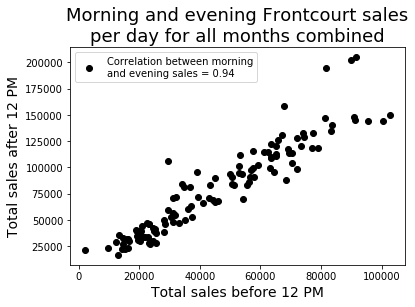

In [35]:
'''
Find correltations between morning and evening sales in Frontcourt
'''

mornsales_tot=[]
nightsales_tot=[]

for m,mon in zip([11,12,1,2,3],['November','December',
                 'January','February','March']):
    
    M=DatetimeIndex(T['CreatedDt']).month.values==m
    
    Tm=T[M]
    
    mornsales=[]
    nightsales=[]
    
    for day in unique(DatetimeIndex(Tm['CreatedDt']).day.values):
        dind=DatetimeIndex(Tm['CreatedDt']).day.values==day
        mind=DatetimeIndex(Tm[dind]['CreatedDt']).hour.values<12
        nind=DatetimeIndex(Tm[dind]['CreatedDt']).hour.values>12
        mornsales.append(Tm[dind][mind]['fl_Total_SalesAmount'].sum())
        nightsales.append(Tm[dind][nind]['fl_Total_SalesAmount'].sum())
    
    mornsales_tot.append(mornsales)
    nightsales_tot.append(nightsales)
    figure()
    title('Morning and evening Frontcourt sales\nper day for '+mon,fontsize=18)
    plot(mornsales,nightsales,'ko',
         label='Correlation between morning\nand evening'+
         ' sales = {:.2f}'.format(corrcoef(mornsales,nightsales)[0,1]))
    legend()
    xlabel('Total sales before 12 PM',fontsize=14)
    ylabel('Total sales after 12 PM',fontsize=14)
    show()
    

MST=[]
NST=[]
for ms,ns,mon in zip(mornsales_tot,nightsales_tot,['Nov','Dec','Jan','Feb','Mar']):
    savetxt(mon+'_FC_day_night_data.csv',array([ms,ns]).T,delimiter=',',header='Sales before 12PM,Sales after 12PM')
    MST+=ms
    NST+=ns
savetxt('total_FC_day_night_data.csv',array([MST,NST]).T,delimiter=',',header='Sales before 12PM,Sales after 12PM')
   
title('Morning and evening Frontcourt sales\nper day for all months combined',fontsize=18)
plot(MST,NST,'ko',
         label='Correlation between morning\nand evening'+
         ' sales = {:.2f}'.format(corrcoef(MST,NST)[0,1]))
legend()
xlabel('Total sales before 12 PM',fontsize=14)
ylabel('Total sales after 12 PM',fontsize=14)
show()


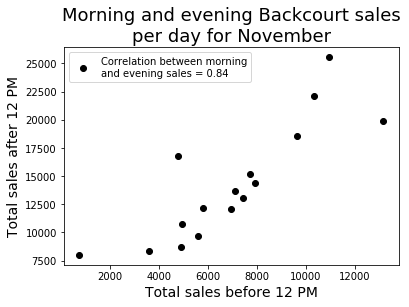

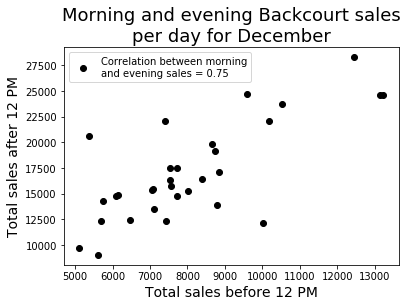

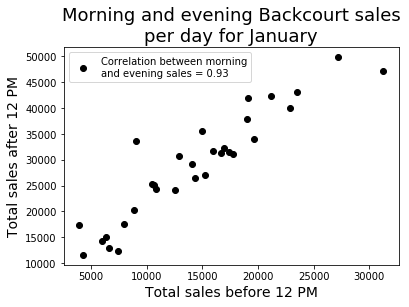

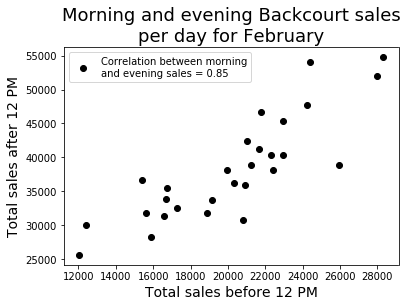

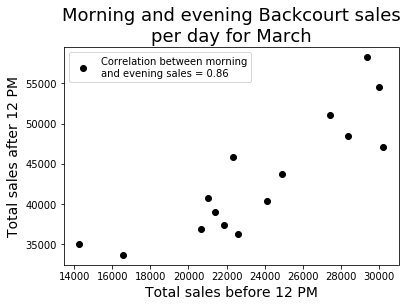

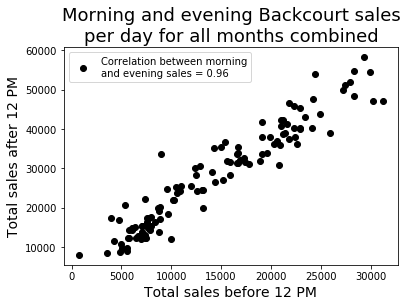

In [37]:
'''
Find correltations between morning and evening sales in backcourt
'''

mornsales_tot=[]
nightsales_tot=[]

for m,mon in zip([11,12,1,2,3],['November','December',
                 'January','February','March']):
    
    M=DatetimeIndex(T['CreatedDt']).month.values==m
    
    Tm=T[M]
    
    mornsales=[]
    nightsales=[]
    
    for day in unique(DatetimeIndex(Tm['CreatedDt']).day.values):
        dind=DatetimeIndex(Tm['CreatedDt']).day.values==day
        mind=DatetimeIndex(Tm[dind]['CreatedDt']).hour.values<12
        nind=DatetimeIndex(Tm[dind]['CreatedDt']).hour.values>12
        mornsales.append(Tm[dind][mind]['il_Total_SalesAmount'].sum())
        nightsales.append(Tm[dind][nind]['il_Total_SalesAmount'].sum())
    
    mornsales_tot.append(mornsales)
    nightsales_tot.append(nightsales)
    figure()
    title('Morning and evening Backcourt sales\nper day for '+mon,fontsize=18)
    plot(mornsales,nightsales,'ko',
         label='Correlation between morning\nand evening'+
         ' sales = {:.2f}'.format(corrcoef(mornsales,nightsales)[0,1]))
    legend()
    xlabel('Total sales before 12 PM',fontsize=14)
    ylabel('Total sales after 12 PM',fontsize=14)
    show()
    

MST=[]
NST=[]
for ms,ns,mon in zip(mornsales_tot,nightsales_tot,['Nov','Dec','Jan','Feb','Mar']):
    savetxt(mon+'_BC_day_night_data.csv',array([ms,ns]).T,delimiter=',',header='Sales before 12PM,Sales after 12PM')
    MST+=ms
    NST+=ns
savetxt('total_BC_day_night_data.csv',array([MST,NST]).T,delimiter=',',header='Sales before 12PM,Sales after 12PM')
      

    
title('Morning and evening Backcourt sales\nper day for all months combined',fontsize=18)
plot(MST,NST,'ko',
         label='Correlation between morning\nand evening'+
         ' sales = {:.2f}'.format(corrcoef(MST,NST)[0,1]))
legend()
xlabel('Total sales before 12 PM',fontsize=14)
ylabel('Total sales after 12 PM',fontsize=14)
show()


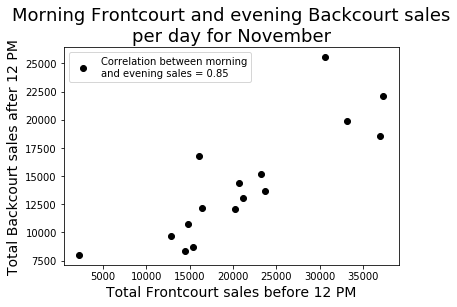

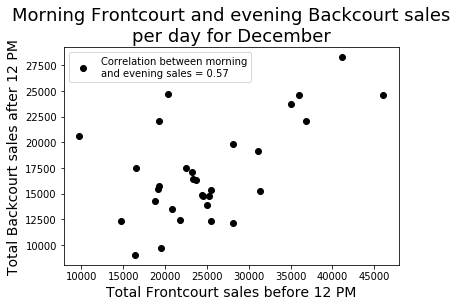

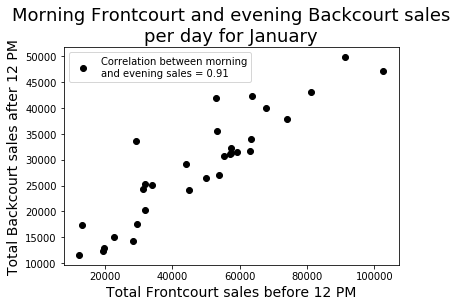

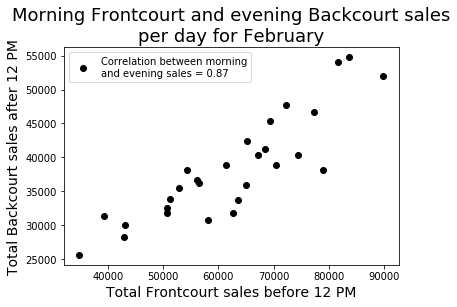

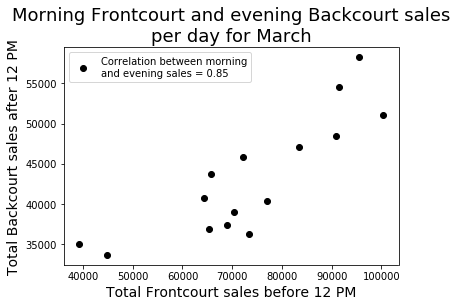

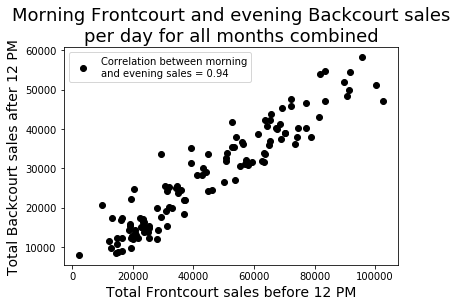

In [30]:
'''
Find correltations between morning frontcourt sales and evening backcourt sales.
'''

mornsales_tot=[]
nightsales_tot=[]

for m,mon in zip([11,12,1,2,3],['November','December',
                 'January','February','March']):
    
    M=DatetimeIndex(T['CreatedDt']).month.values==m
    
    Tm=T[M]
    
    mornsales=[]
    nightsales=[]
    
    for day in unique(DatetimeIndex(Tm['CreatedDt']).day.values):
        dind=DatetimeIndex(Tm['CreatedDt']).day.values==day
        mind=DatetimeIndex(Tm[dind]['CreatedDt']).hour.values<12
        nind=DatetimeIndex(Tm[dind]['CreatedDt']).hour.values>12
        mornsales.append(Tm[dind][mind]['fl_Total_SalesAmount'].sum())
        nightsales.append(Tm[dind][nind]['il_Total_SalesAmount'].sum())
    
    mornsales_tot.append(mornsales)
    nightsales_tot.append(nightsales)
    figure()
    title('Morning Frontcourt and evening Backcourt sales\nper day for '+mon,fontsize=18)
    plot(mornsales,nightsales,'ko',
         label='Correlation between morning\nand evening'+
         ' sales = {:.2f}'.format(corrcoef(mornsales,nightsales)[0,1]))
    legend()
    xlabel('Total Frontcourt sales before 12 PM',fontsize=14)
    ylabel('Total Backcourt sales after 12 PM',fontsize=14)
    show()
    

MST=[]
NST=[]
for ms,ns in zip(mornsales_tot,nightsales_tot):
    MST+=ms
    NST+=ns

    
title('Morning Frontcourt and evening Backcourt sales\nper day for all months combined',fontsize=18)
plot(MST,NST,'ko',
         label='Correlation between morning\nand evening'+
         ' sales = {:.2f}'.format(corrcoef(MST,NST)[0,1]))
legend()
xlabel('Total Frontcourt sales before 12 PM',fontsize=14)
ylabel('Total Backcourt sales after 12 PM',fontsize=14)
show()

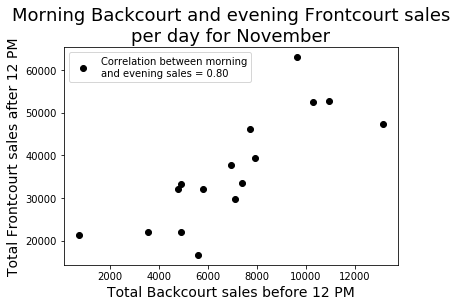

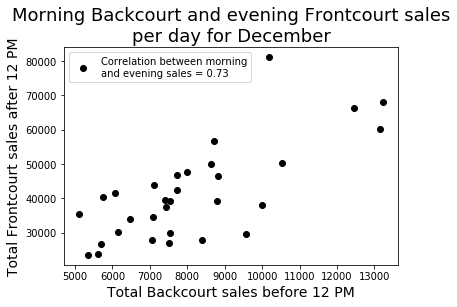

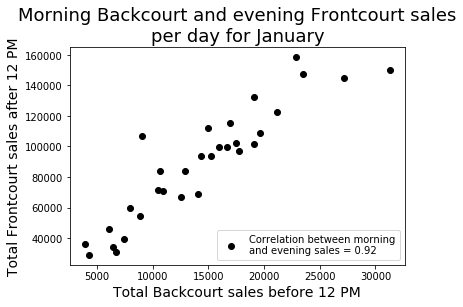

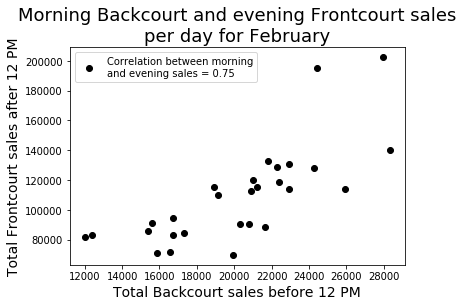

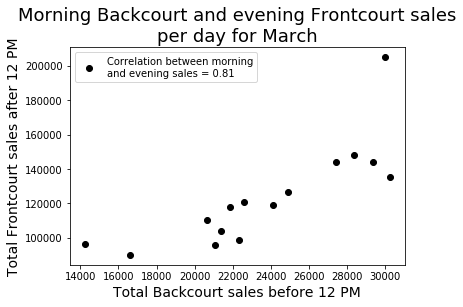

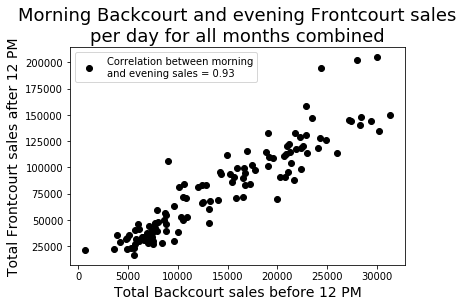

In [31]:
'''
Find correltations between morning backcourt sales and evening frontcourt sales.
'''

mornsales_tot=[]
nightsales_tot=[]

for m,mon in zip([11,12,1,2,3],['November','December',
                 'January','February','March']):
    
    M=DatetimeIndex(T['CreatedDt']).month.values==m
    
    Tm=T[M]
    
    mornsales=[]
    nightsales=[]
    
    for day in unique(DatetimeIndex(Tm['CreatedDt']).day.values):
        dind=DatetimeIndex(Tm['CreatedDt']).day.values==day
        mind=DatetimeIndex(Tm[dind]['CreatedDt']).hour.values<12
        nind=DatetimeIndex(Tm[dind]['CreatedDt']).hour.values>12
        mornsales.append(Tm[dind][mind]['il_Total_SalesAmount'].sum())
        nightsales.append(Tm[dind][nind]['fl_Total_SalesAmount'].sum())
    
    mornsales_tot.append(mornsales)
    nightsales_tot.append(nightsales)
    figure()
    title('Morning Backcourt and evening Frontcourt sales\nper day for '+mon,fontsize=18)
    plot(mornsales,nightsales,'ko',
         label='Correlation between morning\nand evening'+
         ' sales = {:.2f}'.format(corrcoef(mornsales,nightsales)[0,1]))
    legend()
    xlabel('Total Backcourt sales before 12 PM',fontsize=14)
    ylabel('Total Frontcourt sales after 12 PM',fontsize=14)
    show()
    

MST=[]
NST=[]
for ms,ns in zip(mornsales_tot,nightsales_tot):
    MST+=ms
    NST+=ns

    
title('Morning Backcourt and evening Frontcourt sales\nper day for all months combined',fontsize=18)
plot(MST,NST,'ko',
         label='Correlation between morning\nand evening'+
         ' sales = {:.2f}'.format(corrcoef(MST,NST)[0,1]))
legend()
xlabel('Total Backcourt sales before 12 PM',fontsize=14)
ylabel('Total Frontcourt sales after 12 PM',fontsize=14)
show()